In [385]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat, umath, unumpy
from sympy import symbols, pprint
import csv
import scipy.optimize as opt

In [386]:
# Settings + Notes
"""The units used are in SI units."""

# Plotting Settings
plt.style.use("default")

# # remove interactive mode
# plt.ioff()

# # disable images from automatically showing up
# use("Agg")

# Exporting Saved Images
def export_plot(plot, filename, savelocation="../exports/", _quality=95, _dpi=100, _optimize=True):
    """Saves a plot to the specified location."""
    plot.savefig(str(savelocation + filename), quality=_quality, dpi=_dpi, optimize=_optimize)

# Export to CSV
def export_plotting_data(dataArray, pre="", path="../exports/plottingData.csv", reset=False, netSet=False):
    if reset:
        open(path, "w").close()
    file = open(path, "a")
    if netSet:
        file.write("\n")
    file.write(pre)
    wr = csv.writer(file, quoting=csv.QUOTE_ALL)
    wr.writerow(dataArray)
    file.close()

In [387]:
# Constants
G = ufloat(9.81, 0.03)  # the gravitational acceleration measured at UofT MP: https://faraday.physics.utoronto.ca/PVB/Harrison/ErrorAnalysis/Introduction.html

UNCERTAINTY_RULER = 0.005  # meters
UNCERTAINTY_IPHONE = 0.1  # seconds 

LENGTH_SLINKY = ufloat(1.8, UNCERTAINTY_RULER)  # meters

In [388]:
# Equations
def mean(array):
    return sum(array)/len(array)

def standard_deviation(array):
    numerator = 0
    arrayMean = mean(array)
    N = len(array)
    for i in range(N):
        numerator += umath.pow((array[i] - arrayMean), 2)
    return umath.pow((numerator/N), 1/2)

def convert_to_ufloat(data, uncert):
    if not isinstance(data, (list, tuple, set)):
        return ufloat(data, uncert)
    return [ufloat(e, uncert) for e in data]

def seperate_ufloat(data):
    if not isinstance(data, (list, tuple, set)):
        return data.nominal_value, data.std_dev
    nominals, devs = [], []
    for e in data:
        nominals.append(e.nominal_value)
        devs.append(e.std_dev)
    return nominals, devs

/home/divy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


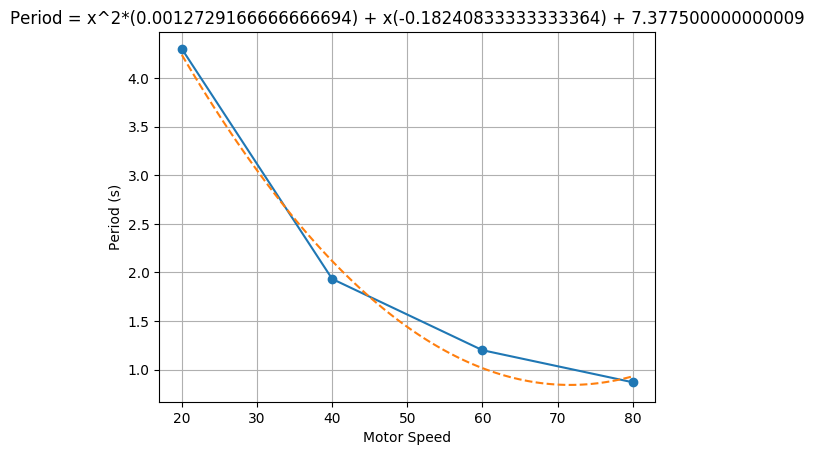

In [389]:
# Deriving a relationship between motor speed and period.
motorSpeed = [i for i in range(20, 100, 20)]
# print(motorSpeed)
periods = [4.3, 5.8/3, 6.0/5, 8.7/10]
# print(periods)

z = np.polyfit(motorSpeed, periods, deg=2)
# generate line of best fit
p = np.poly1d(z)
xp = np.linspace(min(motorSpeed), max(motorSpeed), 100)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Motor Speed")
ax.set_ylabel("Period (s)")
ax.grid(True)
ax.set_title("Period = x^2*({}) + x({}) + {}".format(z[0], z[1], z[2]))
ax.plot(motorSpeed, periods, "-o")
ax.plot( xp, p(xp), "--")
# show figure
fig.show()

In [390]:
# Question 1: Determining c_0

times = [2.2, 1.8, 2.4, 1.9, 1.9, 1.9]
# update times to include uncertainty
for _ in range(len(times)):
    times.append(ufloat(times.pop(0), UNCERTAINTY_IPHONE)) # seconds
# calculate standard deviation and mean of time
sdTimes = standard_deviation(times)
averageTime = sum(times)/len(times)
C0 = LENGTH_SLINKY/averageTime

# pick the greater uncertainty
C0_SD = max(sdTimes, C0.std_dev)
print("The standard deviation for time is {}".format(C0_SD))

# Display the uncertainty
C0 = ufloat(C0.nominal_value, C0_SD.nominal_value)
print("The c_0 value is {} [m/s]".format(C0))
print("Percentage uncertainty: {}".format(C0.std_dev/C0.nominal_value))

"""There is a key assumptions made in this analysis: 

The applied frequency w >> w_0, thus using equation (5) results in c = c_0"""

The standard deviation for time is 0.21+/-0.04
The c_0 value is 0.89+/-0.21 [m/s]
Percentage uncertainty: 0.23693177197444326


'There is a key assumptions made in this analysis: \n\nThe applied frequency w >> w_0, thus using equation (5) results in c = c_0'

In [391]:
# Q2: Determine w_0 for the suspended slinky
height = ufloat(0.87, UNCERTAINTY_RULER)
W0 = umath.pow(G/height, 1/2)
print("The frequency of the slinky-pendulum is {} [rad/s]".format(W0))
print("Percentage Uncertainty: {}".format(W0.std_dev/W0.nominal_value))
print("The periods of the slinky-pendulum is {} [s]".format(2*np.pi/W0))

"""Though we can get a more accurate uncertainty value by taking greater data points, the 3 percentage uncertainty is not unreasonable because of the lower human error involved relative to the calculation of c_0."""

The frequency of the slinky-pendulum is 3.358+/-0.011 [rad/s]
Percentage Uncertainty: 0.003255052311620279
The periods of the slinky-pendulum is 1.871+/-0.006 [s]


'Though we can get a more accurate uncertainty value by taking greater data points, the 3 percentage uncertainty is not unreasonable because of the lower human error involved relative to the calculation of c_0.'

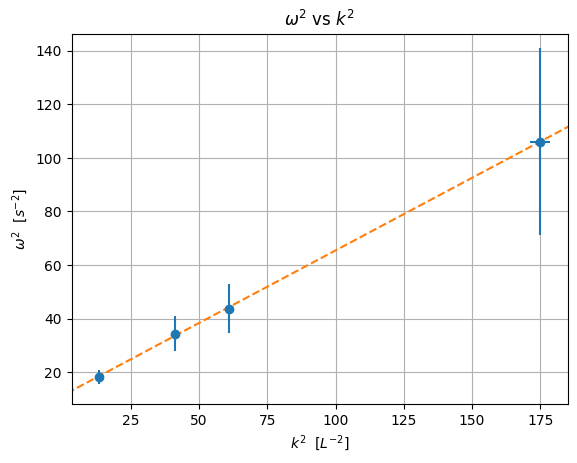

In [392]:
# Q3: Determine k values, plot w^2 vs k^2, deduce w_0^2 and c_0^2
# data
wavelengths = [80.5/100, (128-106)/100, (82-34.5)/100, (192.5 - 94.5)/100, (192.5 - 20)/100]  # meters
periods = [9.5/10, 7.7/10, 6.1/10, 10.7/10, 14.7/10]  # seconds
modes = [3, 3, 4, 2, 1]  # modes = n

# convert to ufloats
wavelengths = convert_to_ufloat(wavelengths, UNCERTAINTY_RULER)
periods = convert_to_ufloat(periods, UNCERTAINTY_IPHONE)

# calculate k^2 values, not do not use kn
K2 = []  # without n
for i in range(len(wavelengths)):
    value = umath.pow(2*np.pi/wavelengths[i], 2)
    K2.append(value)

# determine w^2 using period
W2 = []
for i in range(len(periods)):
    W2.append(umath.pow(2*np.pi/periods[i], 2))

# removed outliers
del W2[1]
del K2[1]

# seperate data and uncertainty
K2_nominal, K2_uncert = seperate_ufloat(K2)
W2_nominal, W2_uncert = seperate_ufloat(W2)

# plot w^2 against k^2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("$k^2$  $[L^{-2}]$")
ax.set_ylabel("$\omega^2$  $[s^{-2}]$")
ax.set_title("$\omega^2$ vs $k^2$")
ax.errorbar(K2_nominal, W2_nominal, W2_uncert, K2_uncert, fmt="o")

# fit the curve
z = np.polyfit(K2_nominal, W2_nominal, deg=1)
p = np.poly1d(z)
xMin = min(K2_nominal)
xMax = max(K2_nominal)
yMin = min(W2_nominal)
yMax = max(W2_nominal)
epsilon = 10
h = 50
xp = np.linspace(xMin - h, xMax + h)
ax.plot(xp, p(xp), "--")

# set limits
ax.set_xlim([xMin - epsilon, xMax + epsilon])
ax.set_ylim([yMin - epsilon, yMax + epsilon + 30])
# ax.annotate(s="Line of Best Fit", xy=(110,p(110)), xytext=(120, 60), arrowprops=dict(arrowstyle="->"))
ax.grid(True)

# save image
export_plot(fig, "q3_wsquared_vs_ksquared")

# export to plottingData
export_plotting_data([], pre="##Q3##", reset=True)
export_plotting_data(W2_nominal, pre="w^2: ")
export_plotting_data(K2_nominal, pre="k^2: ")

In [441]:
# Q5: Plot the decay of amplitude and fit it to one or two exponentials
# data
amplitudes = [1.7, 1.5, 1.2, 0.9, 0.7, 0.6, 0.5, 0.4, 0.2, 0.2, 0.1, 0.1]
positions = np.linspace(15, 180, 12).tolist()

# convert to ufloat
amplitudes = convert_to_ufloat(amplitudes, UNCERTAINTY_RULER)
positions = convert_to_ufloat(positions, UNCERTAINTY_RULER)

# seperate nominal and uncert
amplitudes_nominal, amplitudes_uncert = seperate_ufloat(amplitudes)
positions_nominal, positions_uncert = seperate_ufloat(positions)

# exponential functions for fitting
def one_exponential(x, k):
    return 2 * np.exp(k * x)

def two_exponential(x, k):
    return 2 * (np.exp(k * x) - np.exp(-k * x))

# fitting exponentials
fit1, covar1 = opt.curve_fit(one_exponential, positions_nominal, amplitudes_nominal)
fit2, covar2 = opt.curve_fit(two_exponential, positions_nominal, amplitudes_nominal)

# generate fit-data
amplitude_fit1, amplitude_fit2 = [], []
for i in range(len(amplitudes)):
    amplitude_fit1.append(one_exponential(positions_nominal[i], fit1[0]))
    amplitude_fit2.append(two_exponential(positions_nominal[i], fit2[0]))

# plot with 1 expotential fit
fig = plt.figure()
fig.grid(True)
ax1 = fig.add_subplot(211)
ax1.errorbar(positions_nominal, amplitudes_nominal,positions_uncert, amplitudes_uncert, "o")
ax1.plot(positions_nominal, amplitude_fit1)
#ax1.plot(positions_nominal, amplitude_fit2)






fig.show()

AttributeError: 'Figure' object has no attribute 'grid'